<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/banner_IA.png"  width="1000px" height="250px">




# <center> **07. DATA ANALYSIS: STATISTIC TO DISCRIMINATE CLASSES** </center>



## **Outline**
1. **Discriminating/classify from variable modelling**
2. **CLT-again discr**
3. **Hypothesis test**






In [1]:
#@title **Execute this cell**
#@markdown Please include your student id
import sys
import inspect

group_id = "H2" #@param {type:"string"}
assignment_id = 'ai1-'+group_id +'.20212.python'
code_subject = '1'
student_id = "2210" #@param {type:"string"}
"""
Put your student ID here

Example: student_id =  '2152145'
""" 

"\nPut your student ID here\n\nExample: student_id =  '2152145'\n"

In [2]:
#@title **Execute this cell**
#@markdown **UTILS**
#@markdown Please dont modify any line in this cell

import os
import json
import requests
from collections import namedtuple


Config = namedtuple('Config', ['server_name', 'course_name', 'student_id'])
config = Config(server_name='https://azuregrader.azurewebsites.net/api', 
                course_name='ai1', student_id='2162107')


def check_solution(assignment_id, student_func_str):

    # Set the endpoint and payload.
    payload = {'func_str': student_func_str, 'assignment_id': assignment_id}
    endpoint_url = config.server_name + '/CheckSolution'
    # print(endpoint_url)

    # Make request to server with the data coming from the notebook.
    r = requests.get(endpoint_url, params=payload)
    pprint_json_response(r.json())
    return r


def check_solution_and_evaluate(assignment_id: str, student_func_str: str):

    # Set the endpoint and payload.
    payload = {
        'func_str': student_func_str,
        'assignment_id': assignment_id,
        'student_id': student_id
    }
    endpoint_url = config.server_name + '/CheckAndEvaluateSolution'
    # print(endpoint_url)

    # Make request to server with the data coming from the notebook.
    r = requests.post(endpoint_url, params=payload)
    pprint_json_response(r.json())
    return r


def pprint_json_response(response, indent=0):
    """Pretty print the response."""
    for key, value in response.items():
        print('\t' * indent + str(key.capitalize()))

        # If dictionary, do a recurrent call.
        if isinstance(value, dict):
            pprint_json_response(value, indent + 1)
        else:
            # Enumerate elements if list.
            if isinstance(value, list):
                if len(value) == 1:
                    print('\t' * (indent + 1) + str(value[0]))
                else:
                    for i, e in enumerate(value, start=1):
                        print('\t' * (indent + 1) + f'{i}. {e}')
            else:
                print('\t' * (indent + 1) + str(value))

In [6]:
#@title **MONTAR EL DRIVE** { display-mode: "form" }
import os
from google.colab import drive

path_ai = "course-AI/ai-uis-student" #@param {type:"string"}
path = "/content/drive/My Drive/" + path_ai
drive.mount('/content/drive')
os.chdir(path)
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/course-AI/ai-uis-student


In [3]:
#@title **Load libs** { display-mode: "form" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_theme()
pd.__version__

'1.1.5'

#**1. Discriminating/classify from variable modelling**

From distribution we can answer ans understand population patterns. Such patterns can be codified and evolved in computational tools to support decisions, process, among many others. For instance, in medical aplications, this analysis are the core for **computer aided diagnosis (CADS)**:     


<center> <img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/cads.png" width="400" > </center>


For instance, Observe next distribution of a particular variable. Can we use this information to support diagnosis?

In [10]:
#@title **code**
data_breast = pd.read_csv('data/breast_cancer.csv')
data_breast.diagnosis.replace(to_replace='M', value=1, inplace=True)
data_breast.diagnosis.replace(to_replace='B', value=0, inplace=True)
print(data_breast.shape)
data_breast = data_breast.sample(frac=1)

data_breast.head(10)

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
173,871641,0,11.080,14.71,70.21,372.7,0.10060,0.05743,0.023630,0.02583,0.1566,0.06669,0.2073,1.8050,1.377,19.08,0.014960,0.021210,0.014530,0.015830,0.03082,0.004785,11.35,16.82,72.01,396.5,0.12160,0.08240,0.03938,0.04306,0.1902,0.07313,NaN
536,91979701,1,14.270,22.55,93.77,629.8,0.10380,0.11540,0.146300,0.06139,0.1926,0.05982,0.2027,1.8510,1.895,18.54,0.006113,0.025830,0.046450,0.012760,0.01451,0.003756,15.29,34.27,104.30,728.3,0.13800,0.27330,0.42340,0.13620,0.2698,0.08351,NaN
183,873843,0,11.410,14.92,73.53,402.0,0.09059,0.08155,0.061810,0.02361,0.1167,0.06217,0.3344,1.1080,1.902,22.77,0.007356,0.037280,0.059150,0.017120,0.02165,0.004784,12.37,17.70,79.12,467.2,0.11210,0.16100,0.16480,0.06296,0.1811,0.07427,NaN
418,906024,0,12.700,12.17,80.88,495.0,0.08785,0.05794,0.023600,0.02402,0.1583,0.06275,0.2253,0.6457,1.527,17.37,0.006131,0.012630,0.009075,0.008231,0.01713,0.004414,13.65,16.92,88.12,566.9,0.13140,0.16070,0.09385,0.08224,0.2775,0.09464,NaN
137,868682,0,11.430,15.39,73.06,399.8,0.09639,0.06889,0.035030,0.02875,0.1734,0.05865,0.1759,0.9938,1.143,12.67,0.005133,0.015210,0.014340,0.008602,0.01501,0.001588,12.32,22.02,79.93,462.0,0.11900,0.16480,0.13990,0.08476,0.2676,0.06765,NaN
312,89382602,0,12.760,13.37,82.29,504.1,0.08794,0.07948,0.040520,0.02548,0.1601,0.06140,0.3265,0.6594,2.346,25.18,0.006494,0.027680,0.031370,0.010690,0.01731,0.004392,14.19,16.40,92.04,618.8,0.11940,0.22080,0.17690,0.08411,0.2564,0.08253,NaN
350,899187,0,11.660,17.07,73.70,421.0,0.07561,0.03630,0.008306,0.01162,0.1671,0.05731,0.3534,0.6724,2.225,26.03,0.006583,0.006991,0.005949,0.006296,0.02216,0.002668,13.28,19.74,83.61,542.5,0.09958,0.06476,0.03046,0.04262,0.2731,0.06825,NaN
416,905978,0,9.405,21.70,59.60,271.2,0.10440,0.06159,0.020470,0.01257,0.2025,0.06601,0.4302,2.8780,2.759,25.17,0.014740,0.016740,0.013670,0.008674,0.03044,0.004590,10.85,31.24,68.73,359.4,0.15260,0.11930,0.06141,0.03770,0.2872,0.08304,NaN
348,898690,0,11.470,16.03,73.02,402.7,0.09076,0.05886,0.025870,0.02322,0.1634,0.06372,0.1707,0.7615,1.090,12.25,0.009191,0.008548,0.009400,0.006315,0.01755,0.003009,12.51,20.79,79.67,475.8,0.15310,0.11200,0.09823,0.06548,0.2851,0.08763,NaN
473,9113846,0,12.270,29.97,77.42,465.4,0.07699,0.03398,0.000000,0.00000,0.1701,0.05960,0.4455,3.6470,2.884,35.13,0.007339,0.008243,0.000000,0.000000,0.03141,0.003136,13.45,38.05,85.08,558.9,0.09422,0.05213,0.00000,0.00000,0.2409,0.06743,NaN


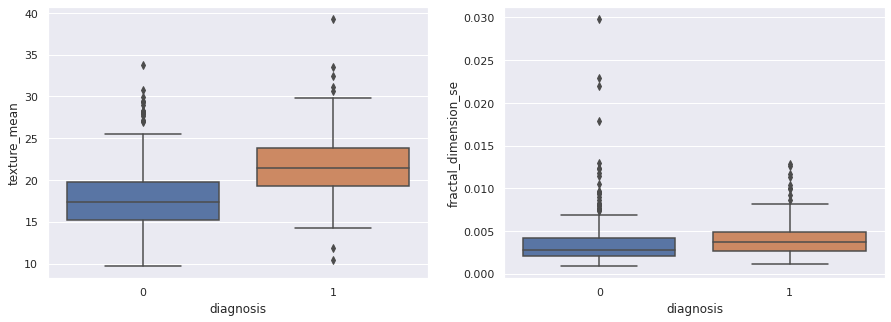

In [11]:
#@title **code** Can you support diagnosis from such variables?
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(x="diagnosis", y="texture_mean", data=data_breast)
plt.subplot(1,2,2)
sns.boxplot(x="diagnosis", y="fractal_dimension_se", data=data_breast)

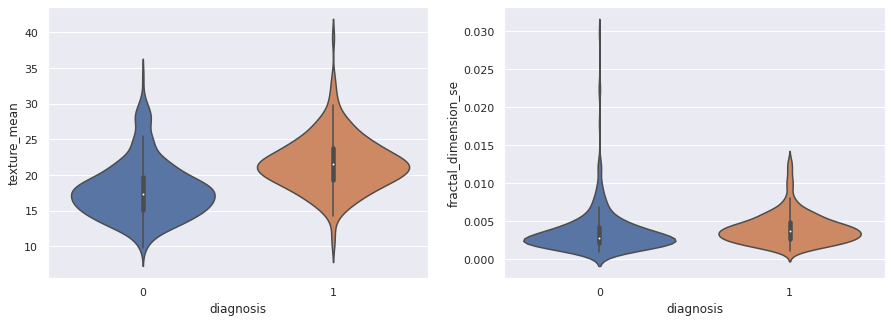

In [12]:
#@title **code**  We can better analyze from violinplots!
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.violinplot(x="diagnosis", y="texture_mean", data=data_breast)
plt.subplot(1,2,2)
sns.violinplot(x="diagnosis", y="fractal_dimension_se", data=data_breast)

We can "simply" compute pdf and cdf and to _"code a rule"_ to decide if the sample belongs to a malignant or benign diagnosis. 

- Suppose that we have the result of a patient with texture mean of = 17.43. (patient id 246). From this result which class correspond?

- Suppose that we have the result of a patient with texture mean of = 22.91. (patient id 118). From this result which class correspond?


**which class (bening or malignant) do you think they belong to? with what probability?**

In [13]:
#@title  **code**

import numpy as np
import scipy.stats as stats

index_benign = 246 #@param {type:"integer"}
index_malign = 118 #@param {type:"integer"}

gt_diag_B = data_breast.diagnosis[index_benign]
t_b_sample = data_breast.texture_mean[index_benign]
t_m_sample = data_breast.texture_mean[index_malign]
gt_diag_M =  data_breast.diagnosis[index_malign]


text_m = data_breast.texture_mean[data_breast.diagnosis ==1]
text_b   = data_breast.texture_mean[data_breast.diagnosis ==0]
text_m_dis =  stats.norm(loc=np.mean(text_m), scale=np.std(text_m))
text_b_dis =  stats.norm(loc=np.mean(text_b), scale=np.std(text_b))
lower_bound = text_m_dis.ppf(0.01); upper_bound = text_m_dis.ppf(0.99)
x, tx_M_cont = np.linspace(lower_bound, upper_bound, 100, retstep=True)
lb = text_b_dis.ppf(0.01); ub = text_b_dis.ppf(0.99)
xb, tx_B_cont = np.linspace(lb, ub, 100, retstep=True)
print('sum 1 the prob', np.sum(tx_M_cont*text_m_dis.pdf(x)))
print('sum 1 the prob', np.sum(tx_B_cont*text_b_dis.pdf(xb)))

def classification_from_stat(text_sample):
  est_b = tx_B_cont*text_b_dis.pdf(text_sample)
  est_m = tx_M_cont*text_m_dis.pdf(text_sample)
  print('est_b: ', est_b, 'est_m: ', est_m)
  class_est = 0 if est_b>est_m else  1
  return class_est


# first classification example
print("estimated class: ", classification_from_stat(t_b_sample), "the ground truth: ", gt_diag_B)

# second classification example
print("estimated class: ", classification_from_stat(t_m_sample), "the ground truth: ", gt_diag_M)

sum 1 the prob 0.9812297466603901
sum 1 the prob 0.9812297466603902
est_b:  0.01861116184057725 est_m:  0.010156881616526328
estimated class:  0 the ground truth:  0
est_b:  0.008561548388983027 est_m:  0.01765892128235922
estimated class:  1 the ground truth:  1


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

We can do the same with the fractal variable. 
- Code a function that compute the prediction of diagnosis class, according to the larger probability with respect to the malignant and benign distributions of `fractal_dimension_se`

** How confident are these results?

In [ ]:
#@title **code student**

#@title **code professor**

index_benign = 246 #@param {type:"integer"}
index_malign = 118 #@param {type:"integer"}

gt_diag_B = data_breast.diagnosis[index_benign]
t_b_sample = data_breast.fractal_dimension_se[index_benign]
t_m_sample = data_breast.fractal_dimension_se[index_malign]
gt_diag_M =  data_breast.diagnosis[index_malign]

def classification_from_stat(text_sample):
  import numpy as np
  import scipy.stats as stats
  data_breast = pd.read_csv('data/breast_cancer.csv')
  data_breast.diagnosis.replace(to_replace='M', value=1, inplace=True)
  data_breast.diagnosis.replace(to_replace='B', value=0, inplace=True)
  
  data_breast = data_breast.sample(frac=1)








  return class_est

# first classification example
print("estimated class: ", classification_from_stat(t_b_sample), "the ground truth: ", gt_diag_B)

# second classification example
print("estimated class: ", classification_from_stat(t_m_sample), "the ground truth: ", gt_diag_M)

# **2.Central Limit Theorem (CLT)**


How much the original breast cancer data belongs to a normal distributions?

- We can run an experiment with multiple samples, to observe how distribution of the mean is approximated to a **Gaussian distribution**

- We need to take some theretical but useful things!!...
- We need to know which means the  **mean**: the expected value
- Then we compute the distribution of multiple means: **The CLT**
- Wewill know about `iid` referred to as independent and identically distributed


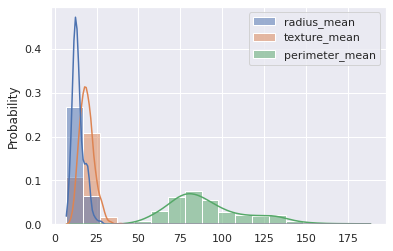

In [ ]:
#@title **code**
subset_variables = list(data_breast.columns)[2:5]
sns.histplot(data=data_breast[subset_variables], kde=True,stat='probability')

### **3.1 Law of Large Numbers**

Law of large numbers (LLN) is a theorem that describes the result of performing the same experiment a large number of identically distributed, randomly generated experiments


$$\bar{X}_n \to \mu \text{ for } n \to \infty$$


1. Take a sample of size 2,3,4,...,1000 from any distritbution
2. Compute the **sample mean** for each sample size
3. Plot the **sample means** and compare them with the actual population mean
4. Repeat 2 times

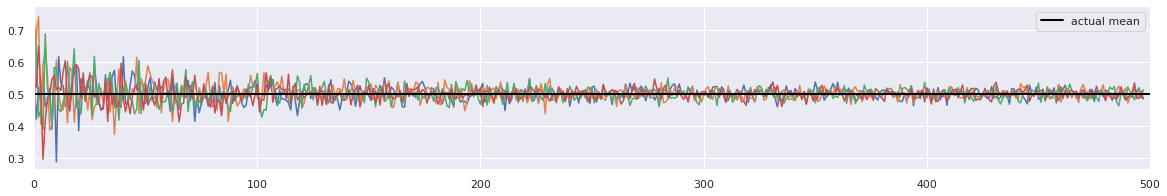

In [ ]:
#@title **code**
plt.figure(figsize=(20,3))
for i in range(1, 5):
    sample_means= [np.mean(np.random.uniform(size=N)) for N in range(2,500)]
    plt.plot(sample_means)#, label="run %d"%i)
    
plt.axhline(0.5, label="actual mean", color="black", lw=2)
plt.xlim(0,500)
plt.legend()

 As the size of a sample is increased the sample mean is more accurate, _i.e._  we can have a measure that better represent 'in general' the population.

 <img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">


Run same experiment for **malignant** _'texture'_ variable, computing from different set of random variables.  

In [ ]:
#@title **code student**




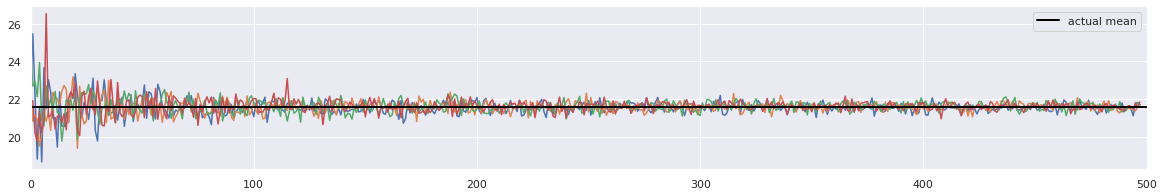

In [ ]:
#@title **code professor**

text_m = data_breast.texture_mean[data_breast.diagnosis ==1]
text_m_dis =  stats.norm(loc=np.mean(text_m), scale=np.std(text_m))

plt.figure(figsize=(20,3))
for i in range(1, 5):
    sample_means= [np.mean(text_m_dis.rvs(size=N)) for N in range(2,500)]
    plt.plot(sample_means)#, label="run %d"%i)
    
plt.axhline(np.mean(text_m), label="actual mean", color="black", lw=2)
plt.xlim(0,500)
plt.legend()



### **2.2 Central Limit Theorem**

The probability distribution of the mean of i.i.d random variables with finite variance is close to a **normal distribution** the the population size increase. 

A summary to proof central limit theorem is: 

1. Take a sample of size N=2 from any distribution
2. Compute the **sample mean**
3. Repeat 100 times

4. Plot the distribution of the **sample mean**
5. Repeat for N=4,10,30

**Agregations of i.i.d. random variables are distributed as a Gaussian**:

$$\frac{X_1 + X_2 + ... + X_N}{N} \sim \mathcal{N} \left ( \mu(X), \frac{\sigma(X)}{\sqrt{N}} \right )$$

**i.i.d** if each random variable has the same distribution and all of them are mutually independent.

The central limit theorem allows us use statistics of samples without know about particular shape distribution of the population. 

See an example to built a Gaussian distribution from a Poisson distribution

0 2
1 10
2 20
3 40


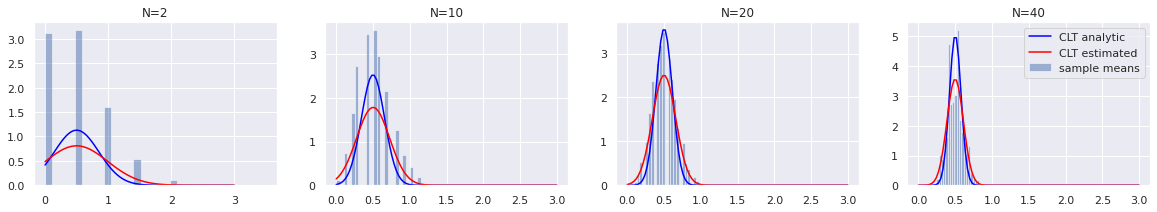

In [ ]:
#@title **code**
plt.figure(figsize=(20,3))

# We start from any distribution

distrib = stats.poisson(mu=0.5)
d_mean = distrib.mean()
d_std  = distrib.mean()


for i,N in enumerate([2,10,20, 40]):
    print( i, N)
    sample_means = []
    # _ is a traditional name for "don't care" 
    for _ in range(10000):
        sample_of_size_N = distrib.rvs(N)
        sample_means.append(np.mean(sample_of_size_N))
    plt.subplot(1,4,i+1)
    x = np.linspace(distrib.ppf(0.01),distrib.ppf(0.99),100)
    plt.hist(sample_means, bins=30, density=True, alpha=.5, label="sample means");
    ref = stats.norm(loc=d_mean, scale=d_std/np.sqrt(N))
    plt.plot(x, ref.pdf(x), label="CLT analytic", color="blue")
    ref = stats.norm(loc=np.mean(sample_means), scale=np.std(sample_means))
    plt.plot(x, ref.pdf(x), label="CLT estimated", color="red")
    plt.title("N=%d"%N)
plt.legend()

Now...
We can built an estimation of a Gaussian distribution of the mean experiments for our variable malingnant of interest. 

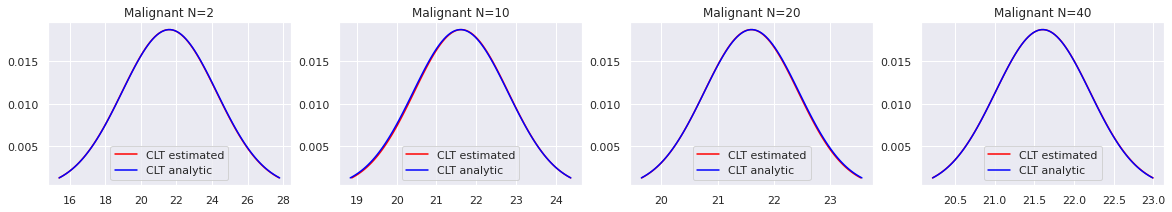

In [14]:
#@title **code**
plt.figure(figsize=(20,3))
text_m = data_breast.texture_mean[data_breast.diagnosis ==1]
text_b   = data_breast.texture_mean[data_breast.diagnosis ==0]
d_mean = np.mean(text_m)
d_std  = np.std(text_m)

for i,N in enumerate([2,10,20, 40]):
  sample_means_m = []
  sample_means_m = np.r_[[np.mean(np.random.choice(text_m, size=N)) for _ in range(10000)]]

  plt.subplot(1,4,i+1)


  estimat_c = stats.norm(loc=np.mean(sample_means_m), scale=np.std(sample_means_m))
  x_ref_estim, ref_cont_estim = np.linspace(estimat_c.ppf(0.01), estimat_c.ppf(0.99), 100, retstep=True)
  plt.plot(x_ref_estim, ref_cont_estim*estimat_c.pdf(x_ref_estim), label="CLT estimated", color="red")


  analyt_c = stats.norm(loc=d_mean, scale=d_std/np.sqrt(N))
  x_ref_analy, ref_cont_analy = np.linspace(analyt_c.ppf(0.01), analyt_c.ppf(0.99), 100, retstep=True)
  plt.plot(x_ref_analy, ref_cont_analy*analyt_c.pdf(x_ref_analy), label="CLT analytic", color="blue")

  #org_c = stats.norm(loc=d_mean, scale=d_std)
  #x_ref_org_c, ref_cont_org_c = np.linspace(org_c.ppf(0.01), org_c.ppf(0.99), 100, retstep=True)
  #plt.plot(x_ref_org_c, ref_cont_org_c*org_c.pdf(x_ref_org_c), label="original", color="orange")

  
  plt.title("Malignant N=%d"%N)  
  plt.legend()

 <img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- Create Gaussian distribution of means for Malignant and bening fractal distributions

In [ ]:
#@title  **code student**



# **3. Confidence for classification from Testing hypothesis**

### **3.1 Confidence intervals**

These intervals shows the probability that a parameter fall into a distribution and around the mean. This intervals allow to measure the degree of uncertainty in a sampling method. 

- The most often used confidence levels is the 68% ($\mu -σ$) 95% ($\mu -2σ$) and 99.7% ($\mu -3σ$)

**Here, we go with a normal distribution!**

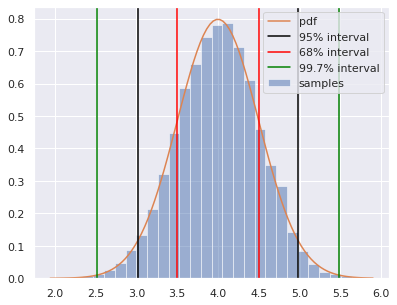

In [ ]:
#@title **code**
plt.figure(figsize=(14,5))
plt.subplot(121)
d1 = stats.norm(loc=4, scale=.5)
samples = d1.rvs(10000)
plt.hist(samples, bins=30, density=True, alpha=.5, label="samples");
t = np.linspace(np.min(samples), np.max(samples), 100)
plt.plot(t, d1.pdf(t), label="pdf")
#Confidence interval with equal areas around the median.
interval1 = d1.interval(.95)
interval2 = d1.interval(.68)
interval3 = d1.interval(.997)
#Add a vertical line across the axes.
plt.axvline(interval1[0], color="black", label="95% interval"); plt.axvline(interval1[1], color="black")
plt.axvline(interval2[0], color="red", label="68% interval"); plt.axvline(interval2[1], color="red")
plt.axvline(interval3[0], color="green", label="99.7% interval"); plt.axvline(interval3[1], color="green")
plt.legend();


### **3.2 Testing hypothesis**

It is a procedure to stablish if a property of a statistical population is compatible with the observed in a sample of the population, ***i.e.***,  it is confirmatory data analysis. 

In average student's grades in a course is 3.9 and its standard deviation is 0.76. This semester, my class of 20 students had an average of 3.5:

- Has something gone wrong this semester?
- Is it just a statistical fluctuation?

**Reformulate the question**: If nothing went wrong, how likely is it to obtain a sample of 20 students having an average of 3.5? 

If it is very unlikely (say <5% probability), then we have evidence to think that this **IS NOT** a random fluctuation.

**Empirically:** Let's answer by brute force.

1. Assume grades follow some distribution with mean 3.9
2. Take a sample of size 20 an compute the **sample mean**
3. Repeat 10000 times step 2
4. Plot the histogram of the **sample means**
5. Is 3.5 within a 95% confidence interval?

**Analytically:** We can also answer with CLT

1. Build a Gaussian distribution with mean and std as described above
2. Compute 95% confidence intervals

3.7470385734585947
P-value
empirical  prob <3.5 = 0.000
analytical prob <3.5 = 0.000


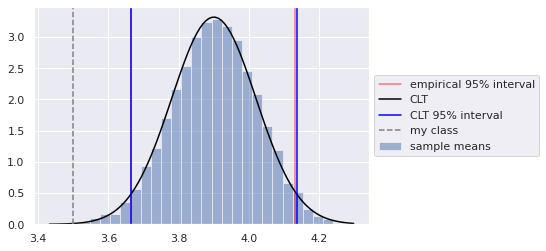

In [ ]:
#@title **code**
def ht(N):
    # first by brute force
    d = stats.beta(5, 1.41)
    print(np.mean(d.rvs(size=N)*5))
    sample_means = np.r_[[np.mean(d.rvs(size=N)*5) for _ in range(10000)]]
    print ("P-value")
    print ("=======")
    print ("empirical  prob <3.5 = %.3f"%np.mean(sample_means<3.5))

    plt.hist(sample_means, bins=30, alpha=.5, density=True, label="sample means");
    empirical_interval = np.percentile(sample_means, [2.5, 97.5])    
    plt.axvline(empirical_interval[0], color="red",  alpha=.5)
    plt.axvline(empirical_interval[1], color="red",  alpha=.5, label="empirical 95% interval")
    
    # now analytical
    t = np.linspace(np.min(sample_means), np.max(sample_means), 100)
    ref = stats.norm(loc=3.9, scale=0.76/np.sqrt(N))
    plt.plot(t, ref.pdf(t), label="CLT", color="black")

    interval = ref.interval(.95)
    plt.axvline(interval[0], color="blue", label="CLT 95% interval")
    plt.axvline(interval[1], color="blue")

    plt.axvline(3.5, color="gray", ls="--", label="my class")
    plt.legend(loc="center left", bbox_to_anchor=(1,.5))

    print("analytical prob <3.5 = %.3f"%ref.cdf(3.5))
    
ht(40)

observe what happens if our class was smaller or larger.

- smaller samples: confidence interval grows, distribution still not converged to normal (CLT needs larger samples)
- larger samples: confidence interval shrinks and CLT works good

3.7547365981044463
P-value
empirical  prob <3.5 = 0.122
analytical prob <3.5 = 0.120


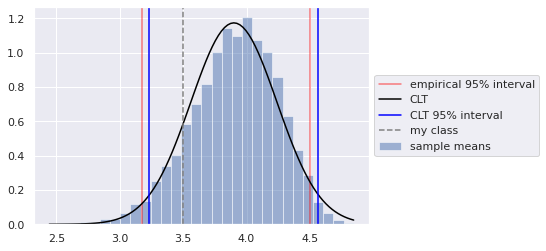

In [ ]:
#@title **code**
ht(5)

 <img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

**Your classifications from texture and fractal measures are confident?**
 - Given two samples index, compute texture or fractal measures. 
 - Compute the analytical CLT from N samples.
 - project index samples into respective distributions and conclude about confidence. 


In [ ]:
# **code student**



---
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/bannerThanks.jpg" alt="Drawing" style="width:700px;">
